In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import boto3
from io import BytesIO
# from s3fs.core import S3FileSystem
import matplotlib.pyplot as plt
from distribution.stable_nromal import StableNormal
from distribution.mixture_same_family import ReparametrizedMixtureSameFamily

In [269]:
import seaborn as sns
import neurokit2 as nk
from tqdm import tqdm
from collections import Counter

In [3]:
s3 = boto3.resource('s3')

In [4]:
class round_bp(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.input = input
        return torch.round(input)

    @staticmethod
    def backward(ctx, grad_output):
        grad_input = grad_output.clone()
        return grad_input

class float_bp(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.input = input
        return float(input)

    @staticmethod
    def backward(ctx, grad_output):
        grad_input = grad_output.clone()
        return grad_input

In [5]:
# load from AWS
data_obj = s3.Bucket("compwell-databucket").Object("processed_DA/sleep_edfe/test_EEG.csv")
data_all = pd.read_csv(BytesIO(data_obj.get()['Body'].read()), sep="\t", header=None)
# data = torch.Tensor(data_all['ECG_signal'][:2]).permute(0,2,1)

In [292]:
data = torch.Tensor(np.expand_dims(data_all.values[:,1:], 1))

In [ ]:
# load from local path
data_all = np.load('/rdf/data/physionet.org/processed_DA/ptbxl/100hz/test_dict_12lead.npy', allow_pickle=True).item()
data = torch.Tensor(data_all['ECG_signal'][0], requires_grad=True).permute(1,0).unsqueeze(0)

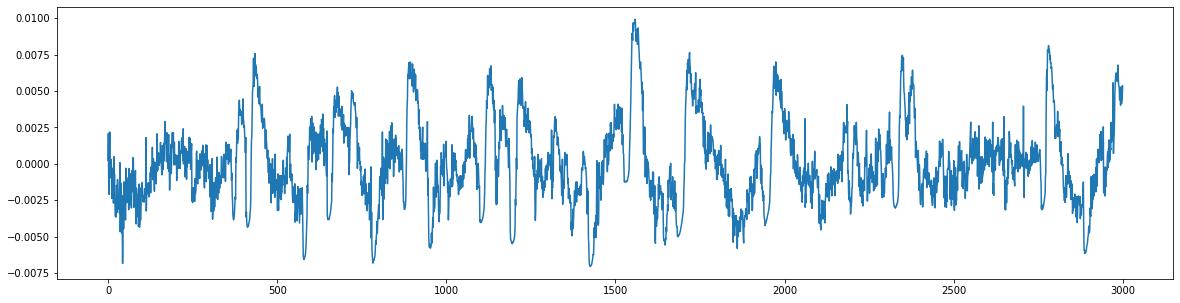

In [7]:
plt.figure(figsize=(20,5))
plt.plot(data[0].T)

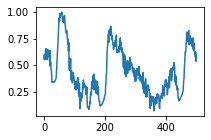

In [293]:
# data = torch.Tensor(data_all['ECG_signal'][:2]).permute(0,2,1)
data -= data.min(2, keepdim=True)[0]
data /= data.max(2, keepdim=True)[0]
plt.figure(figsize=(3,2))
data = data[:,:,1500:2000]
plt.plot(data[0].T)

original_ = data[0].T

In [12]:
data.min(2, keepdim=True)[0]

tensor([[[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.]]])

In [44]:
probabilities_dist = torch.distributions.RelaxedBernoulli(0.1, 0.1)
sample_probabilities = probabilities_dist.rsample()
print(sample_probabilities.grad_fn)

None


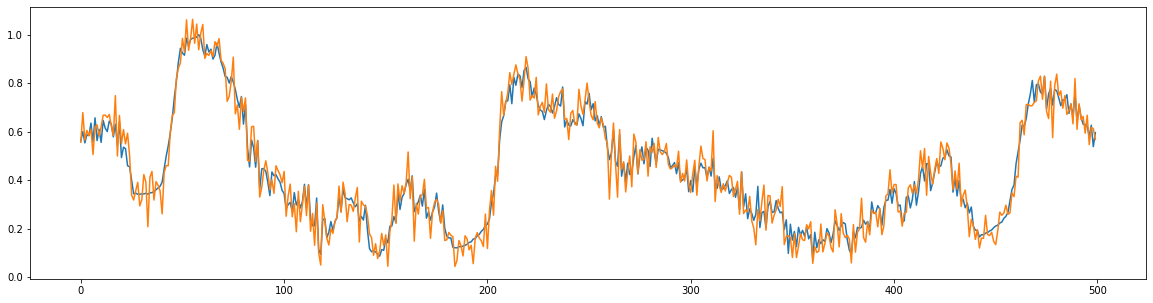

In [9]:
## Jittering
def jitter(x, sigma):
    m = torch.distributions.normal.Normal(loc=0, scale=sigma[0])
    noise = m.rsample(sample_shape=x.size())
    noisy_x = x + noise
    return noisy_x

jitter_sigma = nn.Parameter(0.05 * torch.ones(1), requires_grad=True)
jitter_x = jitter(data, jitter_sigma)
print(jitter_x.grad_fn)
plt.figure(figsize=(20,5))
plt.plot(original_)
plt.plot(jitter_x.detach().numpy()[0].T)
jitter_ = jitter_x.detach().numpy()[0].T

tensor([[1.1504],
        [0.9452],
        [1.0427],
        ...,
        [0.9843],
        [1.1735],
        [0.9273]], grad_fn=<AddBackward0>)
Parameter containing:
tensor([0.1000], requires_grad=True) <MulBackward0 object at 0x7f34a51f0c90>


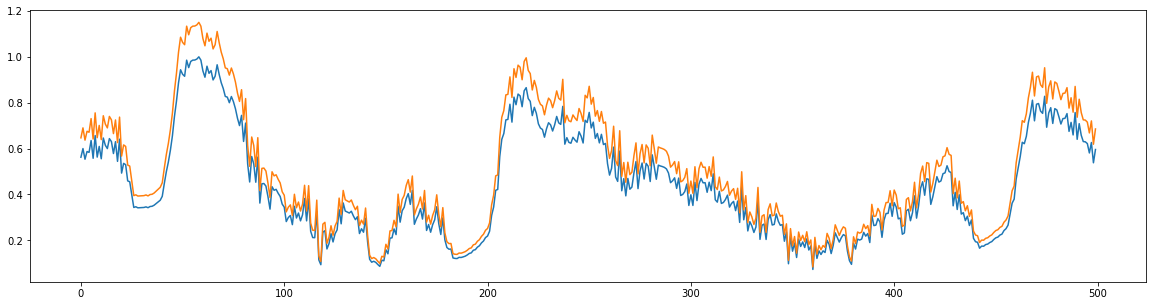

In [219]:
## Scaling
def scaling(x, sigma):
    m = torch.distributions.normal.Normal(loc=1, scale=sigma[0])
    factor = m.rsample(sample_shape=x.size()[:2])
    print(factor)
    output = x * factor.unsqueeze(-1)
    return output

scaling_sigma = nn.Parameter(0.10 * torch.ones(1), requires_grad=True)
scaling_x = scaling(data, scaling_sigma)
print(scaling_sigma, scaling_x.grad_fn)
plt.figure(figsize=(20,5))
plt.plot(original_)
plt.plot(scaling_x.detach().numpy()[0].T)
scaling_ = scaling_x.detach().numpy()[0].T

torch.Size([12329, 1])


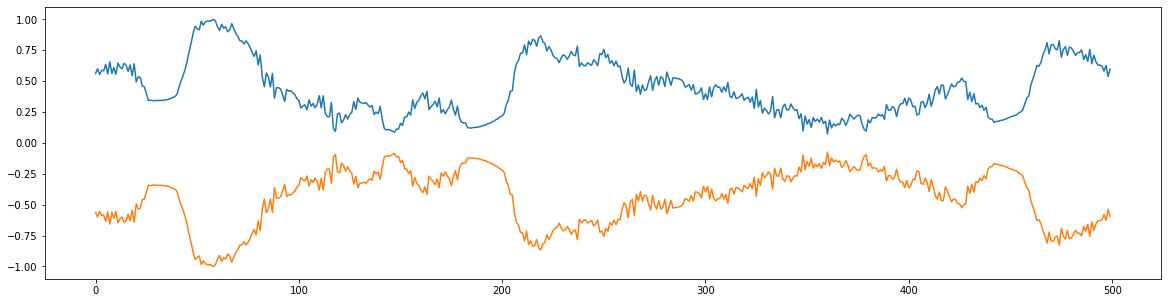

In [183]:
## Rotation
def rotation(x, probs, temperature=0.01):
    """
    x.shape = [batchsize, channel, features]
    """
    m = torch.distributions.relaxed_bernoulli.LogitRelaxedBernoulli(temperature, probs=probs)
    flip = m.rsample()
    flip = F.hardtanh(flip)
    output =  flip.view(x.size()[0], x.size()[1], 1) * x
    return output

rotation_prob = nn.Parameter((1 - 0.1) * torch.ones(data.size()[1]), requires_grad=True)
rotation_prob = rotation_prob.repeat(data.size()[0],1)
print(rotation_prob.shape)
rotation_x = rotation(data, rotation_prob)
print(rotation_x.grad_fn)
plt.figure(figsize=(20,5))
plt.plot(original_)
plt.plot(rotation_x.detach().numpy()[0].T)

/home/hy29/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.


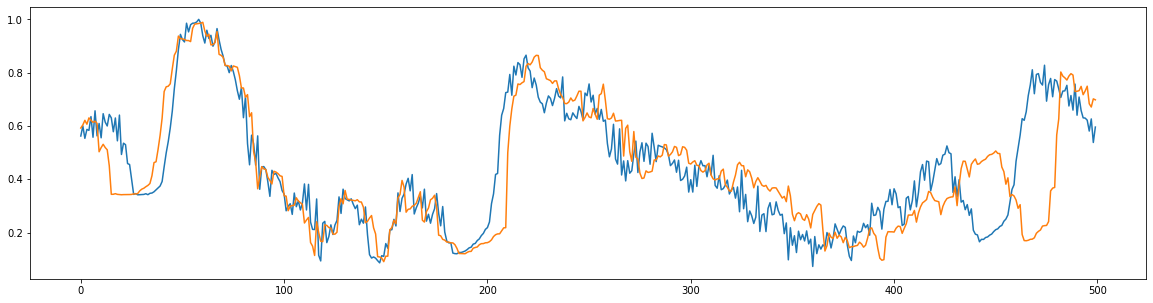

In [17]:
## Time distortion
## Time distortion
def time_distortion(x, mixture_weights, nromal_mean, nromal_sigma):
    mixture_cate = torch.distributions.Categorical(probs=F.softmax(mixture_weights))
    normal_dists = StableNormal(loc=nromal_mean, scale=nromal_sigma)
    mixture_normal = ReparametrizedMixtureSameFamily(mixture_distribution=mixture_cate,
                                                     component_distribution=normal_dists)
    mixture_norm_samples = mixture_normal.rsample(sample_shape=(x.size(0),x.size(2)))
    mixture_norm_samples = torch.tanh(mixture_norm_samples)
    # mixture_norm_samples = (mixture_norm_samples - mixture_norm_samples.min(1)[0]) / (mixture_norm_samples.max(1)[0] - mixture_norm_samples.min(1)[0])
    mixture_norm_samples, _ = torch.sort(mixture_norm_samples)

    x_hw = x.unsqueeze(2)
    grid_hw = mixture_norm_samples.unsqueeze(1)
    grid_hw = torch.cat([grid_hw, 0 * torch.ones_like(grid_hw)], dim=1).permute(0,2,1).unsqueeze(1)
    x_distorted = F.grid_sample(x_hw, grid_hw, align_corners=False).squeeze(-2)
    return x_distorted

mixture_weights = nn.Parameter(torch.ones(3), requires_grad=True)
nromal_mean = nn.Parameter(torch.Tensor([-0.5, 0.0, 0.5]), requires_grad=True)
nromal_sigma = nn.Parameter(torch.Tensor([0.7, 0.7, 0.7]), requires_grad=True)
timeDis_x = time_distortion(data, mixture_weights, nromal_mean, nromal_sigma)
print(timeDis_x.grad_fn)
plt.figure(figsize=(20,5))
plt.plot(original_)
plt.plot(timeDis_x[0,0].detach().numpy().T)
timeDis_ = timeDis_x[0,0].detach().numpy().T
# plt.plot(scaling_x.detach().numpy()[0,0].T)

Parameter containing:
tensor([5.], requires_grad=True) tensor([0.0010])


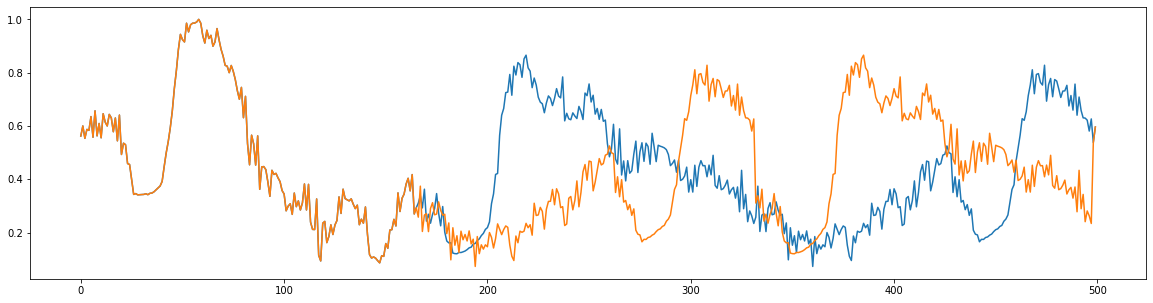

In [16]:
## Permutation
class permuteView(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, num_seg):
        splits = torch.split(x, torch.div(x.size(-1), int(num_seg), rounding_mode='trunc'), dim=-1)
        if x.size(-1) % int(num_seg) == 0:
            permuted_order = torch.randperm(int(num_seg))
        else:
            permuted_order = torch.randperm(int(num_seg) + 1)
        ctx.save_for_backward(num_seg, permuted_order)
        splits_permuted = []
        for idx in permuted_order.detach().numpy():
            splits_permuted.append(splits[idx])
        output = torch.cat(splits_permuted, dim=-1)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        num_seg,permuted_order, = ctx.saved_tensors
        splits = torch.split(grad_output, torch.div(grad_output.size(-1), int(num_seg), rounding_mode='trunc'), dim=-1)
        splits_permuted = []
        for idx in permuted_order:
            splits_permuted.append(splits[idx])
        grad_output = torch.cat(splits_permuted, dim=-1)
        return grad_output, grad_output.mean().unsqueeze(0)

def permutation(x, max_segments):
    m_uniform = torch.distributions.uniform.Uniform(1, max_segments)
    num_segs_soft = m_uniform.rsample(x.size()[:1])
    num_segs = torch.round(num_segs_soft) - num_segs_soft.detach() + num_segs_soft
    permute_x = []
    for i, pat in enumerate(x):
        if num_segs[i] > 1:
            permute_view = permuteView.apply(pat.unsqueeze(0), num_segs[i])
        else:
            permute_view = pat.unsqueeze(0)
        permute_x.append(permute_view)
    return torch.cat(permute_x, dim=0)

permuation_seg = nn.Parameter(5 * torch.ones(1), requires_grad=True)
permuted_x = permutation(data, permuation_seg)
permuted_x.mean().backward()
print(permuation_seg, permuation_seg.grad)
plt.figure(figsize=(20,5))
plt.plot(original_)
plt.plot(permuted_x.detach().numpy()[0].T)
permuted_ = permuted_x.detach().numpy()[0].T

Parameter containing:
tensor([0.1000], requires_grad=True) tensor([-0.0034])


/home/hy29/anaconda3/envs/general_dl/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


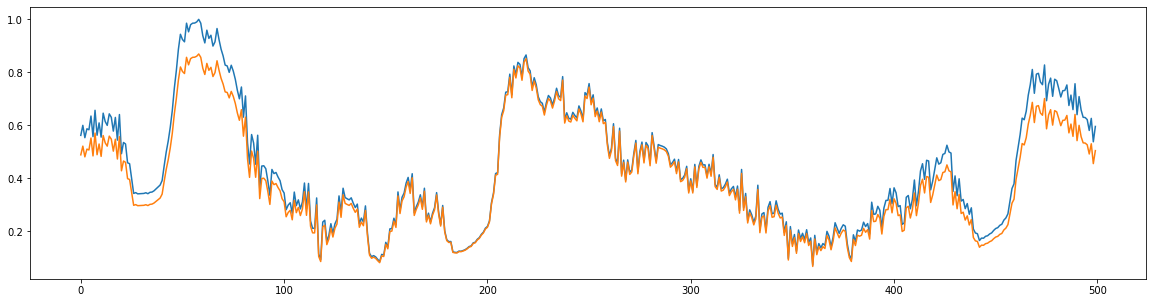

In [19]:
## Magnitude Warping
def magnitude_warp(x, sigma, knot=4):
    m = torch.distributions.normal.Normal(loc=1, scale=sigma[0])
    yy = m.rsample(sample_shape=(x.size(0), x.size(1), knot))
    wave = F.interpolate(yy, size=x.size(2), mode ='linear')
    return wave * x

magW_sigma = nn.Parameter(0.1 * torch.ones(1), requires_grad=True)
magW_x = magnitude_warp(data, magW_sigma)
magW_x.mean().backward()
print(magW_sigma, magW_sigma.grad)
plt.figure(figsize=(20,5))
plt.plot(original_)
plt.plot(magW_x[0].detach().numpy().T)
magW_ = magW_x[0].detach().numpy().T

In [184]:


num_seg = nn.Parameter(5 * torch.ones(1), requires_grad=True)
test_permute = permute_view(data, num_seg)
test_permute.mean().backward()

tensor(8.3333e-05)


In [20]:
from scipy.interpolate import CubicSpline
def time_warp(x, sigma=0.2, knot=4):
    x = np.expand_dims(x, axis=0)

    orig_steps = np.arange(x.shape[1])
    
    random_warps = np.random.normal(loc=1.0, scale=sigma, size=(x.shape[0], knot+2, x.shape[2]))
    warp_steps = (np.ones((x.shape[2],1))*(np.linspace(0, x.shape[1]-1., num=knot+2))).T
    
    ret = np.zeros_like(x)
    for i, pat in enumerate(x):
        for dim in range(x.shape[2]):
            time_warp = CubicSpline(warp_steps[:,dim], warp_steps[:,dim] * random_warps[i,:,dim])(orig_steps)
            scale = (x.shape[1]-1)/time_warp[-1]
            ret[i,:,dim] = np.interp(orig_steps, np.clip(scale*time_warp, 0, x.shape[1]-1), pat[:,dim]).T
    output =  ret
    return np.squeeze(output, axis=0)

timeW_ = time_warp(data[0].T, 0.03)

/home/hy29/.local/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/hy29/.local/lib/python3.7/site-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later


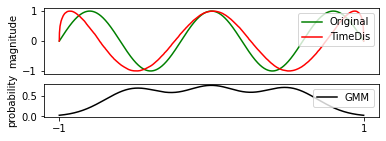

In [422]:
## Time distortion
def time_distortion_forplot(x, mixture_weights, nromal_mean, nromal_sigma):
    mixture_cate = torch.distributions.Categorical(probs=F.softmax(mixture_weights))
    normal_dists = StableNormal(loc=nromal_mean, scale=nromal_sigma)
    mixture_normal = ReparametrizedMixtureSameFamily(mixture_distribution=mixture_cate,
                                                     component_distribution=normal_dists)
    mixture_norm_samples = mixture_normal.rsample(sample_shape=(x.size(0),x.size(2)))
    mixture_norm_samples = torch.tanh(mixture_norm_samples)
    mixture_norm_samples = (mixture_norm_samples - mixture_norm_samples.min(1)[0]) * 2 / (mixture_norm_samples.max(1)[0] - mixture_norm_samples.min(1)[0]) - 1
    mixture_norm_samples, _ = torch.sort(mixture_norm_samples)

    x_hw = x.unsqueeze(2)
    grid_hw = mixture_norm_samples.unsqueeze(1)
    grid_hw = torch.cat([grid_hw, 0 * torch.ones_like(grid_hw)], dim=1).permute(0,2,1).unsqueeze(1)
    x_distorted = F.grid_sample(x_hw, grid_hw, align_corners=False).squeeze(-2)
    return x_distorted, mixture_norm_samples

Fs = 80000
f = 5
sample = 40000
sine_x = np.arange(sample)
sine_y = np.sin(2 * np.pi * f * sine_x / Fs)


mixture_weights = nn.Parameter(torch.ones(3), requires_grad=True)
nromal_mean = nn.Parameter(torch.Tensor([-0.5, 0.0, 0.5]), requires_grad=True)
nromal_sigma = nn.Parameter(torch.Tensor([0.4, 0.4, 0.4]), requires_grad=True)
timeDis_x, mixture_norm_samples = time_distortion_forplot(torch.Tensor(sine_y).unsqueeze(0).unsqueeze(0), mixture_weights, nromal_mean, nromal_sigma)


f, (ax1, ax2) = plt.subplots(2,1,figsize=(6,2), gridspec_kw={'height_ratios': [2, 1]})
ax1.plot(sine_x, sine_y, color='green', linewidth=1.5, label="Original")
ax1.plot(sine_x, timeDis_x[0,0].detach().numpy(), color='red', linewidth=1.5, label="TimeDis")
ax1.set_xticks([])
ax1.set_ylabel("magnitude")
ax1.legend(loc=1)

ax2.plot(x, pdf, '-k', label="GMM")
# ax1.plot(sine_x, timeDis_x[0,0].detach().numpy(), color='red', linewidth=1.5)
# ax1.set_xticks([])
ax2.set_ylabel("probability")
ax2.legend(loc=1)
ax2.set_xticks([-1,1])
plt.savefig("/rdf/user/hy29/plots/iclr_2022/time_dis.pdf", bbox="tight")

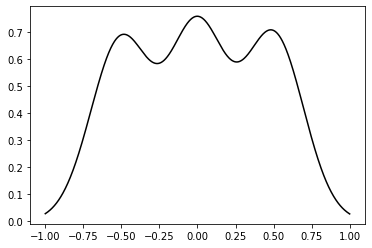

In [404]:
from sklearn.mixture import GaussianMixture
mus =  np.array([[-0.5], [0.0], [0.5]])
sigmas = np.array([[0.45], [0.45],  [0.45]]) ** 2
gmm = GaussianMixture(3)
gmm.means_ = mus
gmm.covars_ = sigmas
gmm.weights_ = np.array([1, 1, 1])

#Fit the GMM with random data from the correspondent gaussians
gaus_samples_1 = np.random.normal(mus[0], sigmas[0], 10000).reshape(10000,1)
gaus_samples_2 = np.random.normal(mus[1], sigmas[1], 10000).reshape(10000,1)
gaus_samples_3 = np.random.normal(mus[2], sigmas[2], 10000).reshape(10000,1)
fit_samples = np.concatenate((gaus_samples_1, gaus_samples_2, gaus_samples_3))
gmm.fit(fit_samples)

fig = plt.figure()
ax = fig.add_subplot(111)
x = np.linspace(-1, 1, 1000).reshape(1000,1)
logprob = gmm.score_samples(x)
pdf = np.exp(logprob)
#print np.max(pdf) -> 19.8409464401 !?
ax.plot(x, pdf, '-k')
plt.show()


In [400]:
gmm.fit(mixture_norm_samples[0].detach().numpy().reshape(1, -1))
x = np.linspace(-1, 1, 1000).reshape(1000,1)
logprob = gmm.score_samples(x)
pdf = np.exp(logprob)
#print np.max(pdf) -> 19.8409464401 !?
ax.plot(x, pdf, '-k')
plt.show()

ValueError: Found array with 1 sample(s) (shape=(1, 40000)) while a minimum of 2 is required.

(array([0.00375   , 0.03124994, 0.04625004, 0.08500008, 0.11124977,
        0.16625016, 0.22000021, 0.30374938, 0.33750032, 0.34375033,
        0.37749923, 0.38250036, 0.45625044, 0.49125047, 0.48249902,
        0.51500049, 0.5237505 , 0.55624887, 0.58125055, 0.58375056,
        0.5937488 , 0.57625055, 0.57250055, 0.60499877, 0.62000059,
        0.57874969, 0.60125057, 0.59124968, 0.62749966, 0.60875058,
        0.60624967, 0.62000059, 0.64124966, 0.64624965, 0.60875058,
        0.61499967, 0.65749965, 0.60250013, 0.59000012, 0.56750012,
        0.60125013, 0.59749968, 0.64500013, 0.6224999 , 0.68625014,
        0.64499989, 0.60000001, 0.56875001, 0.59875001, 0.63375001,
        0.64375001, 0.66500001, 0.63000001, 0.62625001, 0.6237499 ,
        0.62375013, 0.6287499 , 0.61250013, 0.62374967, 0.62375013,
        0.62250013, 0.63125013, 0.60500013, 0.61999967, 0.64749965,
        0.63750061, 0.61249967, 0.61624967, 0.51750049, 0.59249968,
        0.6325006 , 0.61874967, 0.66749964, 0.63

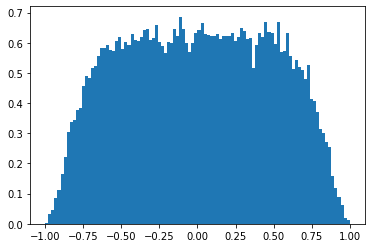

In [389]:
plt.hist(mixture_norm_samples[0].detach().numpy(), bins=100, density=True)

/home/hy29/.local/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
  del sys.path[0]


<Figure size 1440x360 with 0 Axes>

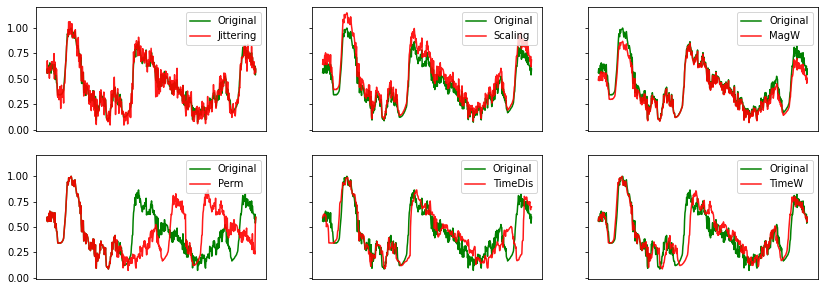

In [225]:
plt.figure(figsize=(20,5))
f, axs = plt.subplots(2,3, sharey=True, sharex=True, figsize=(14,5))
aug_labels = ["Jittering", "Scaling", "MagW", "Perm", "TimeDis", "TimeW"]
for i, aug_data in enumerate([jitter_, scaling_, magW_, permuted_, timeDis_, timeW_]):
    
#     plot_df = pd.DataFrame(np.concatenate([original_, aug_data], axis=1), columns=["Original", aug_labels[i]])
#     sns.lineplot(data=plot_df, ax=axs[i//3, i%3])
    
    axs[i//3, i%3].plot(original_, label='Original', alpha=1, color='green', linewidth=1.5)
    axs[i//3, i%3].plot(aug_data, label=aug_labels[i], alpha=0.9, color='red', linewidth=1.5)
    axs[i//3, i%3].legend(loc=1)
    axs[i//3, i%3].set_xticks([])
plt.savefig("/rdf/user/hy29/plots/iclr_2022/augmentations.pdf", bbox="tight")

/home/hy29/.local/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
  del sys.path[0]


<Figure size 1440x216 with 0 Axes>

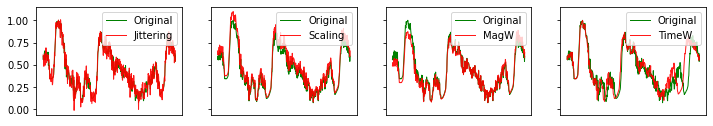

In [236]:
plt.figure(figsize=(20,3))
f, axs = plt.subplots(1,4, sharey=True, sharex=True, figsize=(12,2))
aug_labels = ["Jittering", "Scaling", "MagW", "TimeW"]
for i, aug_data in enumerate([jitter_, scaling_, magW_, timeW_]):
    
#     plot_df = pd.DataFrame(np.concatenate([original_, aug_data], axis=1), columns=["Original", aug_labels[i]])
#     sns.lineplot(data=plot_df, ax=axs[i//3, i%3])
    
    axs[i].plot(original_, label='Original', alpha=1, color='green', linewidth=1)
    axs[i].plot(aug_data, label=aug_labels[i], alpha=0.9, color='red', linewidth=1)
    axs[i].legend(loc=1)
    axs[i].set_xticks([])
plt.savefig("/rdf/user/hy29/plots/imwut_2022/augmentations.pdf", bbox="tight")

In [197]:
axs[]

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

In [99]:
x_distorted.mean().backward()
mixture_weights.grad

tensor([ 0.0406, -0.0250, -0.0156])

In [285]:
x = data
knot = 2
orig_steps = np.arange(x.shape[2])

random_warps = np.random.normal(loc=1.0, scale=0.2, size=(x.shape[0], x.shape[1], knot+2))
warp_steps = (np.ones((x.shape[1],1))*(np.linspace(0, x.shape[2]-1., num=knot+2)))
ret = np.zeros_like(x)
for i, pat in enumerate(x):
    time_warp = CubicSpline(warp_steps[:,1], warp_steps[:,1] * random_warps[i, 0])(orig_steps)
    scale = (x.shape[2]-1)/time_warp[-1]
    ret[i] = np.interp(orig_steps, np.clip(scale*time_warp, 0, x.shape[2]-1), pat).T
output =  ret

ValueError: operands could not be broadcast together with shapes (12,) (4,) 

In [286]:
random_warps[i, 0]

array([1.02022587, 0.66804056, 0.95860785, 0.95538015])

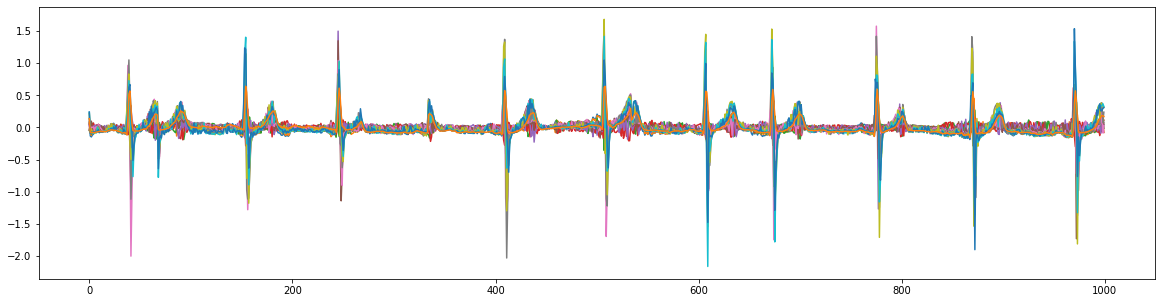

In [260]:
plt.figure(figsize=(20,5))
plt.plot(output[0].T)

In [148]:
test = torch.arange(9).unsqueeze(1).repeat(1, 10)
test

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
        [3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
        [4, 4, 4, 4, 4, 4, 4, 4, 4, 4],
        [5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
        [6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
        [7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
        [8, 8, 8, 8, 8, 8, 8, 8, 8, 8]])

In [151]:
test.size()

torch.Size([9, 10])

tensor(1.1277, grad_fn=<SelectBackward0>)
torch.Size([1, 12, 1127])
Parameter containing:
tensor([0.2000], requires_grad=True) None


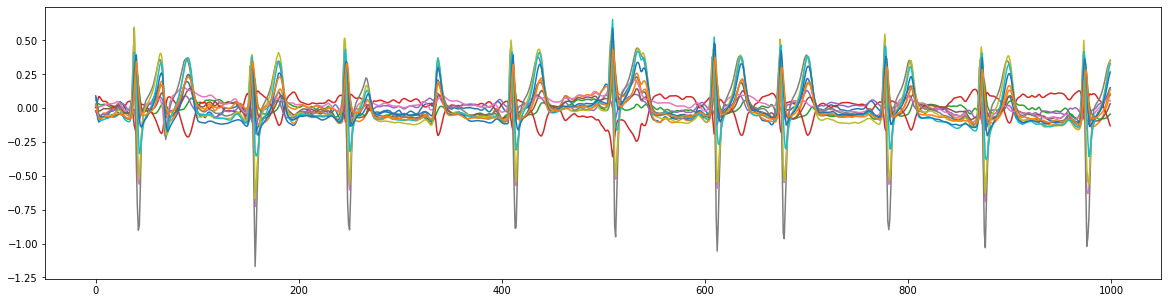

In [321]:
## Time Warping
def round_node(node, length):
    while length % node != 0:
        node -= 1
    return node

def time_warp(x, sigma, knot=8):
    node = round_node(knot, x.size(0))
    # segment_length = int(x.size(0) / node)
    m = torch.distributions.normal.Normal(loc=1, scale=sigma[0])
    timeW_random = m.rsample(sample_shape=(x.size(0), node))
    # timeW_random = round_bp(timeW_random)
    x_trunc = x.view(x.size(0), x.size(1), node, x.size(2) // node)
    for i in range(x.size(0)):
        pat = []
        for j in range(node):
            segment = x_trunc[i,:,j,:]
            print(timeW_random[i, j])
            segment_interpolate = F.interpolate(segment.unsqueeze(0), scale_factor=float_bp.apply(timeW_random[i, j]), mode='linear')
            print(segment_interpolate.size())
            pat.append(segment_interpolate)
        x[i] = F.interpolate(torch.cat(pat), size=x.size(2), mode='linear')
    return x

timeW_sigma = nn.Parameter(0.2 * torch.ones(1), requires_grad=True)
timeW_x = time_warp(data, timeW_sigma)
# timeW_x.mean().backward()
print(timeW_sigma, timeW_sigma.grad_fn)
plt.figure(figsize=(20,5))
plt.plot(timeW_x[0].detach().numpy().T)

In [20]:
# load from AWS (apnea_ECG)
data_obj = s3.Bucket("compwell-databucket").Object("processed_DA/sleep_apnea/sleep_apnea_test.csv")
data = pd.read_csv(BytesIO(data_obj.get()['Body'].read()), sep='\t', header=None)

In [22]:
ecg, labels = data.values[:, 1:], data.values[:,0]

In [48]:
ecg_sample = ecg[500]
ecg_sample = torch.Tensor(ecg_sample).unsqueeze(0).unsqueeze(0)
ecg_sample.shape

torch.Size([1, 1, 6000])

In [301]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

def normalization(x):
    x -= x.min(2, keepdim=True)[0]
    x /= (x.max(2, keepdim=True)[0] + 0.00000001)
    return x

def aug(x, jitter_sigma, scaling_sigma, rotation_prob, mixture_weights, nromal_mean, nromal_sigma, permuation_seg, magW_sigma):
    e = 1e-8
    x = jitter(x, 0.03 * torch.sigmoid(jitter_sigma) + e)
    x = scaling(x, 0.05 * torch.sigmoid(scaling_sigma) + e)
#     x = rotation(x, torch.sigmoid(rotation_prob).repeat(x.size(0), 1))
    x = time_distortion(x, mixture_weights, nromal_mean, F.relu(nromal_sigma) + e)
#     x = permutation(x, permuation_seg)
    x = magnitude_warp(x, 0.05 * torch.sigmoid(magW_sigma) + e)
#     x = normalization(x)
    return x

In [316]:
jitter_sigma, scaling_sigma, rotation_prob, mixture_weights, nromal_mean, nromal_sigma, permuation_seg, magW_sigma = [torch.Tensor(p) for p in [jitter_sigma, scaling_sigma, rotation_prob, mixture_weights, nromal_mean, nromal_sigma, permuation_seg, magW_sigma]]
nromal_mean = torch.Tensor([-0.75, -0.5, -0.25, 0.0, 0.25, 0.5, 0.75])
nromal_sigma = torch.Tensor([0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8])
mixture_weights = torch.Tensor([1, 1, 1, 1, 1, 1, 1])
aug_ecg = aug(original_ecg_tensor, jitter_sigma, scaling_sigma, rotation_prob, mixture_weights, nromal_mean, nromal_sigma, permuation_seg, magW_sigma)

tensor([[0.9744]], grad_fn=<AddBackward0>)


/home/hy29/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  after removing the cwd from sys.path.
/home/hy29/anaconda3/envs/general_dl/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=linear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [295]:
original_ecg_tensor = torch.Tensor(original_ecg).unsqueeze(0).unsqueeze(0)

/home/hy29/.local/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later
  


<Figure size 360x144 with 0 Axes>

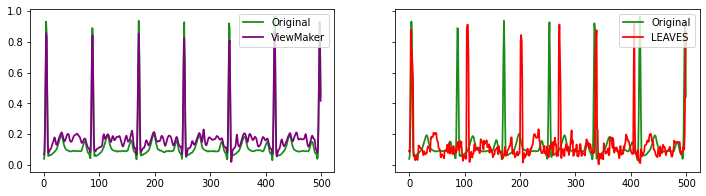

In [318]:
plt.figure(figsize=(5,2))
f, axs = plt.subplots(1,2, sharey=True, sharex=True, figsize=(12,3))

# sns.lineplot(x=range(len(original_ecg)), y=original_ecg, label='Original', alpha=0.9, ax=axs[0])
# sns.lineplot(x=range(len(original_ecg)), y=viewMaker_ECG, label='ViewMaker', alpha=0.9, ax=axs[0])
axs[0].plot(original_ecg, label='Original', alpha=0.9, linewidth=1.75, color="green")
axs[0].plot(viewMaker_ECG, label='ViewMaker', linewidth=1.75, color="purple")
# plt.plot(aug_ecg.detach().numpy()[0,0, :500], label='Ours')
axs[0].legend(loc=1)

axs[1].plot(original_ecg, label='Original', alpha=0.9, linewidth=1.75, color="green")
# axs[1].plot(viewMaker_ECG, label='viewMaker')
plt.plot(aug_ecg.detach().numpy()[0,0, :500], label='LEAVES', color="red", linewidth=1.75)
axs[1].legend(loc=1)

plt.savefig("/rdf/user/hy29/plots/iclr_2022/viewmaker_vs_ours.pdf", bbox="tight")

In [112]:
aug_params_apnea = np.load('/home/hy29/rdf/viewmaker_physiological/experiments/sleep_apnea/init_run/params_dict.npy', allow_pickle=True).item()
aug_params_edfe = np.load('/home/hy29/rdf/viewmaker_physiological/experiments/sleep_edfe/init_run/params_dict.npy', allow_pickle=True).item()
aug_params_ptbxl = np.load('/home/hy29/rdf/viewmaker_physiological/experiments/ptbxl/init_run/params_dict.npy', allow_pickle=True).item()
aug_params_pamap = np.load('/home/hy29/rdf/viewmaker_physiological/experiments/PAMAP2/init_run/params_dict.npy', allow_pickle=True).item()

In [49]:
jitter_sigma, scaling_sigma, rotation_prob, mixture_weights, nromal_mean, nromal_sigma, permuation_seg, magW_sigma = aug_params[99]

In [159]:
def modify_hyper(hyper, target = 0.05, factor=1):
    delta = target - hyper
    return target - factor * delta

1
1
1
1


/home/hy29/.local/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later


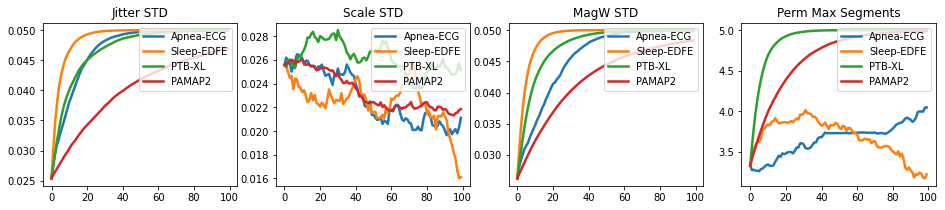

In [426]:

f, axs = plt.subplots(1,4, figsize=(16,3))
hyper_param_idx = [0, 1, -1, -2]
hp_name = ["Jitter STD", "Scale STD", "MagW STD", "Perm Max Segments"]
targets = [0.05, 0.025, 0.05, 5]
factors = [1, 1.5, 1, 50]
for j in range(4):
    idx = hyper_param_idx[j]
    print(factors[i])
    base_factor = 0.05
    if j == 3:
        base_factor = 5
    axs[j].plot([modify_hyper(base_factor * sigmoid(aug_params_apnea[i][idx]), targets[j], factors[j]) for i in range(100)], label='Apnea-ECG' ,linewidth=2.5)
    axs[j].plot([modify_hyper(base_factor * sigmoid(aug_params_edfe[i][idx]), targets[j], factors[j]) for i in range(100)], label='Sleep-EDFE',linewidth=2.5)
    axs[j].plot([modify_hyper(base_factor * sigmoid(aug_params_ptbxl[i][idx]), targets[j], factors[j]) for i in range(100)], label='PTB-XL',linewidth=2.5)
    axs[j].plot([modify_hyper(base_factor * sigmoid(aug_params_pamap[i][idx]), targets[j], factors[j]) for i in range(100)], label='PAMAP2',linewidth=2.5)
    axs[j].legend(loc=1)
    axs[j].set_title(hp_name[j])
plt.savefig("/rdf/user/hy29/plots/iclr_2022/view_hyperparams.pdf", bbox="tight")

In [134]:
pamap2 = np.load('/rdf/data/physionet.org/processed_DA/PAMAP2_Dataset/dataset_train.npy', allow_pickle=True)

In [294]:
original_ecg = np.array([0.03939033, 0.05406863, 0.23798302, 0.6119934 , 0.9315011 ,
       0.8516459 , 0.42895108, 0.1129129 , 0.05695218, 0.06828353,
       0.06380401, 0.06201832, 0.06259003, 0.06484623, 0.06845047,
       0.07205695, 0.07499278, 0.07725795, 0.08019825, 0.08448657,
       0.08844066, 0.0920605 , 0.09669188, 0.10300768, 0.11235369,
       0.12472989, 0.13778111, 0.15083446, 0.16355345, 0.17459226,
       0.18428732, 0.19162928, 0.1925807 , 0.18377708, 0.16690063,
       0.14834388, 0.13281707, 0.12065662, 0.11118963, 0.10441605,
       0.10033585, 0.09827612, 0.09588166, 0.09315247, 0.09278009,
       0.09140001, 0.0876664 , 0.08696241, 0.08827867, 0.08858709,
       0.08788766, 0.08786258, 0.09053052, 0.09286341, 0.09250607,
       0.09080426, 0.08977665, 0.09043256, 0.09075326, 0.09006583,
       0.08971602, 0.09004027, 0.09036563, 0.0900192 , 0.08900093,
       0.0886566 , 0.08932262, 0.08931673, 0.09301274, 0.10512092,
       0.1192487 , 0.13034931, 0.14111434, 0.1498615 , 0.1525534 ,
       0.14683485, 0.13102359, 0.11083924, 0.09435655, 0.08325776,
       0.0765335 , 0.0731744 , 0.06712436, 0.04458894, 0.04291398,
       0.18692213, 0.53515553, 0.88910913, 0.8854178 , 0.491446  ,
       0.14121307, 0.0584578 , 0.06620787, 0.05982758, 0.05748518,
       0.05951711, 0.06188597, 0.06391886, 0.06628867, 0.06933185,
       0.07338484, 0.07642894, 0.07812771, 0.0815092 , 0.08623693,
       0.09163803, 0.09838539, 0.10715192, 0.11726473, 0.12805091,
       0.14051981, 0.15399857, 0.16680494, 0.17692022, 0.18400799,
       0.18773179, 0.18338136, 0.16927448, 0.1511308 , 0.13433349,
       0.12022839, 0.10982486, 0.10379581, 0.09978614, 0.09645005,
       0.09412401, 0.09247161, 0.09182932, 0.09152426, 0.09155645,
       0.09125303, 0.08859532, 0.0859385 , 0.08631063, 0.08836596,
       0.08941291, 0.08877863, 0.08747248, 0.08717674, 0.0889008 ,
       0.09096243, 0.09167943, 0.09105182, 0.09042545, 0.09047324,
       0.08884007, 0.08788113, 0.09028804, 0.091687  , 0.09073225,
       0.08977894, 0.09286453, 0.10402642, 0.11821791, 0.1283736 ,
       0.13853091, 0.15239081, 0.1615421 , 0.15925583, 0.14519559,
       0.12373521, 0.10429534, 0.09091336, 0.08358932, 0.08097744,
       0.07904036, 0.06364721, 0.03580738, 0.08367058, 0.3253305 ,
       0.7133478 , 0.9361706 , 0.72430295, 0.30148378, 0.07649875,
       0.06078718, 0.06963848, 0.06436098, 0.06446875, 0.0665973 ,
       0.06973728, 0.07254291, 0.07366837, 0.07580526, 0.07828069,
       0.0800853 , 0.08424712, 0.08942036, 0.09190404, 0.09506268,
       0.10293362, 0.11282528, 0.12372828, 0.1369884 , 0.15159628,
       0.1675519 , 0.18283653, 0.19442213, 0.20163575, 0.19943063,
       0.1841058 , 0.16306312, 0.14572315, 0.13174938, 0.11676795,
       0.10447977, 0.09959509, 0.09942228, 0.09790521, 0.09369805,
       0.09218395, 0.09336286, 0.09218801, 0.08899578, 0.0868142 ,
       0.08530676, 0.08312761, 0.08162251, 0.08247365, 0.08534454,
       0.08821642, 0.08974345, 0.08958913, 0.0884263 , 0.08928296,
       0.0911497 , 0.09133486, 0.0898384 , 0.08733316, 0.08819292,
       0.09039892, 0.08924083, 0.08942886, 0.09163585, 0.09586176,
       0.10748971, 0.12180933, 0.13444674, 0.1484299 , 0.15736623,
       0.15351735, 0.1392383 , 0.12058514, 0.10159517, 0.08664218,
       0.0790906 , 0.07523941, 0.07306986, 0.06080616, 0.0387847 ,
       0.09784669, 0.351039  , 0.7347726 , 0.92740214, 0.6813009 ,
       0.2578897 , 0.05451511, 0.05099008, 0.06731423, 0.06816033,
       0.06732272, 0.06581069, 0.06665222, 0.07018369, 0.0747228 ,
       0.07791433, 0.07773954, 0.07823574, 0.08276737, 0.08897923,
       0.09417966, 0.0983686 , 0.10491049, 0.11582396, 0.12774447,
       0.13798036, 0.15023252, 0.16416445, 0.17506582, 0.18529171,
       0.19248691, 0.18924952, 0.17793462, 0.1608973 , 0.13948332,
       0.12143098, 0.1107776 , 0.10516802, 0.1019106 , 0.0996595 ,
       0.09774178, 0.09481161, 0.09221476, 0.09196989, 0.09071248,
       0.08709671, 0.08650571, 0.08961239, 0.09002417, 0.08807748,
       0.08780969, 0.08888433, 0.09029204, 0.09035055, 0.08838696,
       0.08742929, 0.08915977, 0.09055037, 0.08991881, 0.08760155,
       0.08561728, 0.08699403, 0.08904021, 0.08906423, 0.08841189,
       0.08910189, 0.09651741, 0.11166781, 0.12647831, 0.1379209 ,
       0.14767782, 0.1523846 , 0.1463216 , 0.12814303, 0.10659662,
       0.09244873, 0.0850265 , 0.07861032, 0.07320018, 0.06274004,
       0.03612709, 0.04181004, 0.20360222, 0.5682701 , 0.9204862 ,
       0.8881378 , 0.46853325, 0.1162155 , 0.04045597, 0.06024501,
       0.06556378, 0.06381419, 0.06239815, 0.06602599, 0.06998747,
       0.07091812, 0.07184602, 0.07478991, 0.07941338, 0.08336132,
       0.08562443, 0.08855788, 0.09350753, 0.1011463 , 0.1104649 ,
       0.12011757, 0.13212305, 0.1451356 , 0.1554543 , 0.16543436,
       0.17541227, 0.18168713, 0.18257675, 0.17740826, 0.16685465,
       0.15024303, 0.13093796, 0.11735071, 0.10948134, 0.10329251,
       0.10013006, 0.09797536, 0.09480975, 0.09298843, 0.09116568,
       0.08866862, 0.08818892, 0.08939017, 0.08958085, 0.08943389,
       0.09096806, 0.09317405, 0.09436968, 0.0952279 , 0.09574877,
       0.09492298, 0.09375995, 0.09394198, 0.09513267, 0.09598628,
       0.09549352, 0.09365444, 0.09147844, 0.08930204, 0.08779818,
       0.08730336, 0.09017278, 0.09876164, 0.10970551, 0.11896704,
       0.12789208, 0.13849938, 0.1474245 , 0.14995721, 0.14138725,
       0.1223876 , 0.1020424 , 0.08640781, 0.07682966, 0.07297157,
       0.07146907, 0.05751844, 0.02977395, 0.07302083, 0.31208178,
       0.71432126, 0.9668416 , 0.7691936 , 0.32627496, 0.07647902,
       0.05446004, 0.06575046, 0.06257451, 0.06175468, 0.06127233,
       0.06247328, 0.06434822, 0.06622428, 0.06944729, 0.07334437,
       0.07757913, 0.08147867, 0.08504304, 0.0892816 , 0.0948673 ,
       0.10280948, 0.11142594, 0.12004381, 0.1320276 , 0.14771377,
       0.16306497, 0.17505316, 0.1843513 , 0.19129583, 0.19117647,
       0.17961943, 0.16066211, 0.14271577, 0.12813553, 0.11557566,
       0.10604551, 0.10055443, 0.09775666, 0.09529706, 0.09283921,
       0.09071957, 0.08927459, 0.08816786, 0.08672649, 0.08629628,
       0.0865408 , 0.08645073, 0.08703543, 0.08863134, 0.08955625,
       0.08947372, 0.09006601, 0.09099668, 0.09125639, 0.09017227,
       0.08875367, 0.08868285, 0.08895048, 0.08922012, 0.08915532,
       0.08841967, 0.0880225 , 0.08863673, 0.09429977, 0.10635742,
       0.11841715, 0.13014252, 0.14287937, 0.15023513, 0.15019113,
       0.14241093, 0.12521231, 0.10465133, 0.08880281, 0.07934898,
       0.07393472, 0.07155068, 0.06412209, 0.03886388, 0.04792569,
       0.22285916, 0.59697276, 0.9297053 , 0.8647571 , 0.4435115 ])

viewMaker_ECG = np.array([0.0677866 , 0.08210433, 0.2610756 , 0.5884475 , 0.8572712 ,
       0.8248104 , 0.45738143, 0.1433255 , 0.07689052, 0.08600777,
       0.08920851, 0.09872298, 0.10328406, 0.10892212, 0.12146758,
       0.13328446, 0.14365831, 0.15137586, 0.16405478, 0.17884998,
       0.17309707, 0.15129557, 0.13354252, 0.1292612 , 0.13550758,
       0.14817762, 0.1606003 , 0.17090374, 0.18150938, 0.19084165,
       0.19935583, 0.20802099, 0.21137798, 0.20539525, 0.19074702,
       0.175048  , 0.15975134, 0.15192172, 0.1574083 , 0.1656681 ,
       0.17610514, 0.18912564, 0.19745575, 0.20043454, 0.20178437,
       0.19282433, 0.17236659, 0.1578851 , 0.15119213, 0.14966954,
       0.15238217, 0.15840693, 0.16892692, 0.17970686, 0.18687046,
       0.19159204, 0.19428691, 0.1954087 , 0.19705251, 0.2014844 ,
       0.20320748, 0.19847143, 0.19203117, 0.18785065, 0.1846155 ,
       0.1779927 , 0.16648658, 0.15325701, 0.1424554 , 0.14302059,
       0.15041232, 0.15701714, 0.16484699, 0.17082593, 0.1712296 ,
       0.16665861, 0.15344515, 0.13713813, 0.12458878, 0.11614831,
       0.11101765, 0.10697137, 0.10097037, 0.0818103 , 0.08542129,
       0.20325018, 0.49475464, 0.82436746, 0.84166527, 0.51632637,
       0.19235131, 0.0959359 , 0.09062104, 0.08686878, 0.09450713,
       0.10261931, 0.10432409, 0.10574152, 0.10875352, 0.11113284,
       0.11363335, 0.11645669, 0.11704694, 0.11683068, 0.11916989,
       0.13046339, 0.15514979, 0.18853006, 0.19970635, 0.18249677,
       0.16866118, 0.17217943, 0.18044144, 0.18855916, 0.19471125,
       0.19899243, 0.19774275, 0.18903036, 0.17468081, 0.16237096,
       0.15270025, 0.14855713, 0.15947905, 0.17659846, 0.18772295,
       0.18494546, 0.17068505, 0.16090651, 0.16094646, 0.16752641,
       0.17609611, 0.18129632, 0.18174884, 0.18080866, 0.18240857,
       0.18603182, 0.18784587, 0.18267748, 0.16893354, 0.15496424,
       0.14117983, 0.12997775, 0.1206072 , 0.12035383, 0.13220379,
       0.14372635, 0.15700142, 0.17442936, 0.18773608, 0.18912235,
       0.17520797, 0.15777889, 0.15064454, 0.15578468, 0.16103217,
       0.16794194, 0.1803155 , 0.19600785, 0.21237612, 0.22235522,
       0.20297894, 0.16102426, 0.12657847, 0.11029571, 0.1060967 ,
       0.10825407, 0.09318522, 0.06516877, 0.11420774, 0.31660193,
       0.62942666, 0.85354644, 0.70620674, 0.32931453, 0.10637818,
       0.08242495, 0.08982231, 0.09489958, 0.10472237, 0.10980822,
       0.10902539, 0.11297303, 0.12612206, 0.14279956, 0.15692548,
       0.1602385 , 0.15164638, 0.13986392, 0.12944323, 0.12615311,
       0.1321544 , 0.14144254, 0.15066496, 0.16183136, 0.17454095,
       0.18558341, 0.19676971, 0.20725127, 0.21320987, 0.21274708,
       0.2013568 , 0.18334876, 0.16743788, 0.15869801, 0.15312067,
       0.15005393, 0.15261625, 0.15542461, 0.15568662, 0.15512964,
       0.16179642, 0.17725885, 0.18748826, 0.18801123, 0.18349992,
       0.1735197 , 0.15877303, 0.1440931 , 0.12833604, 0.1234099 ,
       0.13343239, 0.14769208, 0.16262376, 0.17468011, 0.18325356,
       0.18865222, 0.19035791, 0.18911728, 0.18544742, 0.18031976,
       0.17021811, 0.15469268, 0.13875136, 0.12834504, 0.12507012,
       0.13332076, 0.14653906, 0.15851139, 0.17172556, 0.18169719,
       0.17970958, 0.16790144, 0.15107642, 0.13443515, 0.12571885,
       0.12201914, 0.11810562, 0.11829674, 0.10439084, 0.06934842,
       0.11850888, 0.37252843, 0.6639548 , 0.8213706 , 0.656605  ,
       0.28620446, 0.061345  , 0.05846822, 0.07052659, 0.09360361,
       0.10788742, 0.10827976, 0.1082878 , 0.11112207, 0.11351698,
       0.120975  , 0.13471243, 0.15128857, 0.15485212, 0.1446513 ,
       0.13466482, 0.13080986, 0.13349262, 0.14172986, 0.15103117,
       0.15940446, 0.16991244, 0.18161806, 0.1909177 , 0.20014298,
       0.20720494, 0.20564687, 0.19568592, 0.1823782 , 0.16215532,
       0.147391  , 0.1626615 , 0.20686978, 0.23062125, 0.20827053,
       0.16718858, 0.14235516, 0.1285152 , 0.12680954, 0.13711733,
       0.15021712, 0.1644355 , 0.1759798 , 0.17965251, 0.17772079,
       0.1757234 , 0.17257635, 0.16804826, 0.1646899 , 0.1621505 ,
       0.16296537, 0.1659509 , 0.16671126, 0.16712897, 0.16950658,
       0.17440906, 0.18344355, 0.18853706, 0.18555608, 0.18245363,
       0.17876902, 0.16966103, 0.16474743, 0.16408007, 0.16627479,
       0.17202581, 0.17351115, 0.1647157 , 0.14785534, 0.12937763,
       0.11917896, 0.11636388, 0.11549356, 0.11284682, 0.10291769,
       0.08057455, 0.08180651, 0.21327974, 0.48998395, 0.773785  ,
       0.8078896 , 0.49015963, 0.1246234 , 0.01856844, 0.05799069,
       0.08945785, 0.10107529, 0.10301529, 0.10846874, 0.11204339,
       0.11589367, 0.13202307, 0.17187637, 0.19599529, 0.17336455,
       0.13805404, 0.12235528, 0.11859562, 0.12294519, 0.13042048,
       0.14099981, 0.15447947, 0.16802385, 0.17967574, 0.19006535,
       0.19930215, 0.20440355, 0.20466222, 0.20037618, 0.1914989 ,
       0.17731619, 0.15652132, 0.14650121, 0.15745166, 0.17590556,
       0.19281116, 0.20140868, 0.2001254 , 0.19292764, 0.18274376,
       0.171709  , 0.16378698, 0.16164227, 0.16402587, 0.17249878,
       0.18106988, 0.18250805, 0.17847185, 0.17049241, 0.15440515,
       0.1359435 , 0.12222239, 0.11829883, 0.11954048, 0.12369606,
       0.12964752, 0.13761954, 0.1495386 , 0.16215909, 0.17426768,
       0.18140505, 0.1796495 , 0.1743707 , 0.16706064, 0.16101721,
       0.1591568 , 0.1633625 , 0.16883168, 0.17156218, 0.16448563,
       0.14837241, 0.13138793, 0.11730666, 0.10933253, 0.10586804,
       0.10443155, 0.09522383, 0.07139859, 0.10241134, 0.31834316,
       0.66455215, 0.86360365, 0.72948545, 0.35717827, 0.10328813,
       0.05624424, 0.06949422, 0.08431865, 0.09922148, 0.10144639,
       0.10736108, 0.12192175, 0.1403176 , 0.1578291 , 0.16537625,
       0.1552081 , 0.13884376, 0.12599425, 0.12115601, 0.12370804,
       0.13201997, 0.13979584, 0.14720641, 0.15840961, 0.16945899,
       0.18028045, 0.18917511, 0.19520566, 0.20374501, 0.20733327,
       0.19756038, 0.17987736, 0.16762058, 0.15839197, 0.15331414,
       0.1616308 , 0.17442472, 0.18447746, 0.19226168, 0.20090143,
       0.20971993, 0.21000475, 0.19576421, 0.17594889, 0.16628268,
       0.16483918, 0.16728443, 0.17031497, 0.17065734, 0.16849162,
       0.16619687, 0.1656017 , 0.16597256, 0.16695988, 0.16833737,
       0.17516907, 0.19130799, 0.20014705, 0.18828952, 0.16292733,
       0.13997146, 0.12494007, 0.11809412, 0.12064695, 0.13158971,
       0.14428689, 0.15713978, 0.17047927, 0.18646821, 0.18967752,
       0.18195307, 0.17226219, 0.16866115, 0.16721879, 0.14441842,
       0.11070917, 0.09796433, 0.09475957, 0.07814476, 0.09134434,
       0.25266945, 0.5270625 , 0.80470407, 0.7784443 , 0.4165598 ])

In [253]:
num_peaks = 0


i = 0
_, rpeaks = nk.ecg_peaks(original_, sampling_rate=100)
_, waves_peak = nk.ecg_delineate(aug_ecg.detach().numpy()[0,0, :500], 
                                 rpeaks, 
                                 sampling_rate=100,
                                 show=False)

num_peaks += len(rpeaks)

In [240]:
data_numpy = np.squeeze(data.numpy(), axis=1)


In [264]:
nk.ecg_quality(viewMaker_ECG, sampling_rate=100, method="zhao2018")

'Barely acceptable'

In [287]:

data_qualities_original = []

for ecg in tqdm(data_numpy):
    data_qualities_original.append(nk.ecg_quality(ecg, sampling_rate=100, method="zhao2018", approach="fuzzy"))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12329/12329 [01:15<00:00, 164.30it/s]


In [289]:

data_qualities_LEAVES = []

for ecg in tqdm(aug_ecg.detach().numpy()):
    data_qualities_LEAVES.append(nk.ecg_quality(ecg[0], sampling_rate=100, method="zhao2018", approach="fuzzy"))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12329/12329 [01:13<00:00, 167.18it/s]


In [288]:
Counter(data_qualities_original)

Counter({'Barely acceptable': 11395, 'Unnacceptable': 391, 'Excellent': 543})

In [290]:
Counter(data_qualities_LEAVES)

Counter({'Barely acceptable': 12329})

In [286]:
nk.ecg_quality(ecg[0], sampling_rate=100).shape

(3000,)

AttributeError: 'list' object has no attribute 'shape'

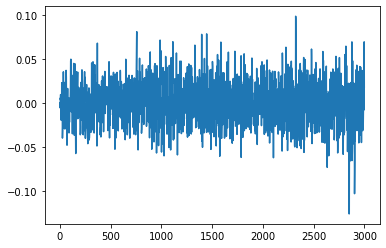

In [283]:
plt.plot(ecg.T)